In [1]:
import numpy as np
import pandas as pd
import scipy

import nltk
import gensim

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


import matplotlib.pyplot as plt
import seaborn as sns

import holidays

## 1.load data

In [2]:
df=pd.read_csv('Data/Data_I-hope.csv')

In [3]:
#concat 2 text col 
df['ProjectDescription']=df['ProjectName']+' '+df['ProjectDescription']

#col set depends on data type
ID_col='ID'

num_cols=['DollarAmount','Hours','SizeOfSpend','MultiAgency','BusinessProcessImpact',
          'TechChange','PublicSafety','MarketRisk','Sensitivity','Leveragability',
          'LevelCalc']
cat_cols=['ProjectColor','ProjectType','CreatedBy','WorkPerformedFor','BuyerName',
          'Division_x','SourcingCategory','CategoryID_x','FedReview','ITComponent',
          'Grouping','CommodityCategory','BuyerInitials','CategoryID_y']
text_cols=['ProjectDescription']
time_cols=['CreateDate']


#useless or 
#can not get before make prediction
drop_cols=['SharePointID','PlanStartDate','PlanFinishDate','StatusDate',
           'Status','RefrenceNumber','ProjectStage','CancelationReason',
           'SensitivityIndicator','ActualFinishDate','Unit','SLA','ProjectName',
           'Planned','SolicitationStatus','LastUpdatedBy','LastUpdateDate',
           'LastUpdatedField','SolicitationNum','Score','Unnamed: 0','Division_y']

In [4]:
df=df.drop(drop_cols,axis=1)
df=df.drop_duplicates(subset=['ID']) #3 duplicates ID
df=df.dropna(subset=['ID'])
df=df.reset_index().drop('index',axis=1)

df.shape

(5490, 28)

## 2.features selection
 - I will only keep features which contain more information. (arbitrary)

In [5]:
noinfo_cols=[]

In [6]:
for col in num_cols:
    df[col]=pd.to_numeric(df[col],errors='coerce')
    median_=df[col].median()
    df[col]=df[col].fillna(median_)

noinfo_cols+=[]
df[num_cols].describe()

,DollarAmount,Hours,SizeOfSpend,MultiAgency,BusinessProcessImpact,TechChange,PublicSafety,MarketRisk,Sensitivity,Leveragability,LevelCalc
count,5.490000e+03,5490.000000,5490.000000,5490.000000,5490.000000,5490.00000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,1.196961e+07,19.573224,3.871949,3.730783,2.988889,3.61020,2.185610,1.904189,3.360656,3.834426,3.405464
std,2.703159e+08,41.402738,1.128554,1.240750,1.035384,1.64292,1.410206,1.295732,1.336587,2.109349,0.956080
min,-3.638138e+08,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,0.000000e+00,4.000000,3.000000,3.000000,2.000000,3.00000,1.000000,1.000000,3.000000,5.000000,3.000000
50%,0.000000e+00,7.000000,4.000000,4.000000,3.000000,5.00000,1.000000,1.000000,3.000000,5.000000,4.000000
75%,2.500000e+05,12.000000,5.000000,5.000000,4.000000,5.00000,3.000000,3.000000,5.000000,5.000000,4.000000
max,1.782678e+10,524.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
#make sure every subgroup has more than 300 samples
#put subgroup which less than 300 samples into an uniform subgroup called 'other'
for col in cat_cols:
    tmp=df.groupby([col]).agg({'ID':'count'})
    keep_group=list(tmp[tmp['ID']>=300].index)
    df.loc[~df[col].isin(keep_group),col]='other'
    
for col in cat_cols:
    tmp=df.groupby([col]).agg({'ID':'count'})
    print('----------------------------------------')
    print(tmp)
    
noinfo_cols+=['ProjectColor','SourcingCategory','CategoryID_x','FedReview','ITComponent',
              'CommodityCategory','CategoryID_y']

----------------------------------------
                ID
ProjectColor      
Green         5468
other           22
----------------------------------------
               ID
ProjectType      
CN           4602
RFP           558
other         330
----------------------------------------
             ID
CreatedBy      
BronzJ     1113
EdgettC     980
Gibrilm     319
baldwins    661
calahanh    385
lugibihlc   304
other      1105
riggs       623
----------------------------------------
                    ID
WorkPerformedFor      
0                  608
1                  384
171                744
271                305
472                367
491                826
551                300
591                331
other             1625
----------------------------------------
             ID
BuyerName      
JAB         382
MW          337
SW2         346
VAH         306
other      4119
----------------------------------------
              ID
Division_x      
COMM        1424
IT          

In [8]:
for col in text_cols+['ID']:
    print(col,len(df),len(set(df[col])))
    
noinfo_cols+=[]

ProjectDescription 5490 5418
ID 5490 5490


In [9]:
for col in time_cols:
    df[col]=pd.to_datetime(df[col])
    df[col]=pd.to_datetime(df[col]).dt.year
    print('--------------------')
    print(df.groupby([col]).agg({'ID':'count'}))
    
noinfo_cols+=[]    

--------------------
              ID
CreateDate      
2017         380
2018        1001
2019        1379
2020        1160
2021        1093
2022         477


In [10]:
print(noinfo_cols)

df=df.drop(noinfo_cols, axis=1)
df.shape

['ProjectColor', 'SourcingCategory', 'CategoryID_x', 'FedReview', 'ITComponent', 'CommodityCategory', 'CategoryID_y']


(5490, 21)

In [11]:
# refresh col set
num_cols=list(set(num_cols)-set(noinfo_cols))
cat_cols=list(set(cat_cols)-set(noinfo_cols))
text_cols=list(set(text_cols)-set(noinfo_cols))
time_cols=list(set(time_cols)-set(noinfo_cols))

# prepare a copy for visualization
df_ori=df.copy(deep=True)

## 3.rescale features before calculate distance

In [12]:
distance_scale=2. #increase numeric variables influence

### 3.1 num_cols

In [13]:
#get rid of outliers
for col in num_cols:
    df.loc[df[col]<0.,col]=0.
    
#rescale with min max scaler
for col in num_cols:
    min_,max_=df[col].min(),df[col].max()
    df[col]=1.*(df[col]-min_)/(max_-min_)*distance_scale

### 3.2 cat_cols

In [14]:
df=pd.get_dummies(df, columns=cat_cols, drop_first=False)

### 3.3 text_cols
 - I will not train words embedding by myself, because words in data is not enough.
 - use words embedding someone already trained (from SIADS655)

In [15]:
# step1.word2vector

## tokenize
tokenized_des=[]
for des in df[text_cols[0]]:
    try:
        tmp=nltk.tokenize.word_tokenize(des)
        tmp=[word for word in tmp if word not in nltk.corpus.stopwords.words('english')] #remove stop-words
        tokenized_des.append(tmp)
    except:
        tokenized_des.append(['empty'])
    
## word to vectors
word_vectors=gensim.models.KeyedVectors.load('Data/wikipedia.100.word-vecs.kv')
### calculate vectors mean for each description
def generate_dense_features(tokenized_des, word_vectors): 
    res=[]
    for doc in tokenized_des:
        tmp_sum=np.zeros(shape=(100,))
        tmp_count=0.
        for word in doc:
            try:
                tmp_sum+=word_vectors[word]
                tmp_count+=1
            except:
                pass
        if tmp_count==0:
            tmp_count=1.
        doc_vector=tmp_sum/tmp_count
        res.append(doc_vector)
    return np.array(res)
emb_des=generate_dense_features(tokenized_des, word_vectors)

print(emb_des.shape)
print('before embedding------------------')
print(df[text_cols[0]][0])
print('after embedding-------------------')
print(emb_des[0])

(5490, 100)
before embedding------------------
Community Ventures To provide wraparound supportive services to Community Ventures participants to help them retain employment.
after embedding-------------------
[-0.01220155  0.23820877  0.76041544  0.50700538  0.65659134 -1.51998037
 -0.56753693 -0.34659729  0.24082493 -0.70303389  0.02928717  0.79408751
  0.4031614   0.00281269  0.35181801 -0.27196477  0.60769969 -0.39203248
 -0.09510558  0.57250364  0.42849201  0.39446694  0.06551165  0.117418
 -0.80193567 -0.08300515  0.87548543 -1.08748535 -0.60115175  0.69524618
  0.58032197 -0.87380087  0.81667297  0.55789545  1.13542063 -0.54709501
 -0.07780902  0.81222285  0.48018072 -0.44335078  0.59288036  0.21837681
  0.39106947 -0.55230062  1.08639726 -0.38032771  1.14477781 -0.59711125
  0.30946145 -0.10874754  0.07249894 -0.13962572  0.07528841  0.67992692
  0.70071482  0.6775002   0.69938541 -0.0717515  -0.42264079  0.65299982
 -0.53104987  0.66782659 -0.67280785 -0.81030715  0.01800514  

In [16]:
# step2 dimension reduction
# (description influence distance too much, it has 100 dim=.=)

# use Z-score rescale data before PCA
mean_=np.mean(emb_des,axis=0)
std_=np.std(emb_des,axis=0)
emb_des=(emb_des-mean_)/std_


pca_model=PCA(n_components=3)
emb_des_lowdim=pca_model.fit_transform(emb_des)

print ('before PCA, embedding dim= ',emb_des.shape)
print ('after PCA, embedding dim= ',emb_des_lowdim.shape)

before PCA, embedding dim=  (5490, 100)
after PCA, embedding dim=  (5490, 3)


In [17]:
## step3 join to the original dataframe
df_des=pd.DataFrame(emb_des_lowdim,columns=['Des_pc1','Des_pc2','Des_pc3'])

df=pd.concat([df,df_des],axis=1)
df=df.drop(['ProjectDescription'],axis=1)

### 3.4 time_cols

In [18]:
col='CreateDate'
min_,max_=df[col].min(),df[col].max()
df[col]=1.*(df[col]-min_)/(max_-min_)*distance_scale

In [19]:
df

,ID,CreateDate,DollarAmount,Hours,SizeOfSpend,MultiAgency,BusinessProcessImpact,TechChange,PublicSafety,MarketRisk,...,WorkPerformedFor_591,WorkPerformedFor_other,BuyerInitials_JAB,BuyerInitials_JW3,BuyerInitials_MDB,BuyerInitials_SB4,BuyerInitials_other,Des_pc1,Des_pc2,Des_pc3
0,3338,0.0,0.001150,0.458015,0.4,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,-0.071914,-5.868991,3.286293
1,3687,0.0,0.000000,0.026718,0.4,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,2.782029,-0.733442,-3.332150
2,3970,0.0,0.000000,0.038168,0.4,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1.008333,-4.387330,-0.340855
3,5015,0.0,0.000000,0.026718,0.4,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,7.011225,-5.947586,0.602039
4,5671,0.0,0.001683,0.458015,0.4,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1.046604,0.378685,-1.284571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,12799,2.0,0.000000,0.026718,0.4,0.5,0.5,0.0,1.0,0.0,...,0,0,0,0,0,0,1,-3.504179,4.093910,0.150299
5486,12860,2.0,0.000000,0.026718,0.4,0.5,0.5,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1.217368,-4.252414,-0.031750
5487,12928,2.0,0.000000,0.026718,0.4,0.5,0.5,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0.711833,-2.748059,-4.141368
5488,12828,2.0,0.000000,0.026718,1.2,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,-2.263777,1.745255,-3.741942


## 4.cluster

In [20]:
#ref
#https://scikit-learn.org/stable/modules/clustering.html

In [21]:
# some utils

def draw_elbow_rule_(tmp):
    tmp=pd.DataFrame(tmp,columns=['k','score'])
    
    sns.set_style("ticks")
    sns.relplot(x='k', y='score', hue="k", 
                alpha=.7, data=tmp)
    
    
def draw_cluster_(cluster_colname):
    sns.set_style("ticks")
    sns.relplot(x="pc1", y="pc2", hue=cluster_colname,
                alpha=.5,data=df_pca)
    
    
def draw_cluster_relationship_(cluster1,cluster2):
    tmp=df_pca[[cluster1,cluster2]].copy(deep=True)
    tmp['mark']=1.
    tmp=pd.pivot_table(tmp, index=cluster1, columns=cluster2, values='mark',aggfunc='sum')
    tmp=tmp.fillna(0.)
    
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(tmp, annot=True, linewidths=.5, ax=ax)
    
    
def draw_variable_distribution_(varname,cluster,cluster_info=False):
    tmp=df_ori[[varname,cluster]].copy(deep=True)
    
    #quantile num_cols
    if varname in num_cols:
        print('quantile mapping---')
        print(df_ori[varname].describe())
        tmp[varname]=pd.qcut(df['Hours'], q=[0, .25, 0.5, .75, 1], labels=['0%-25%', '25%-50%', '50%-75%','75%-100%'])
    
    tmp['count']=1.
    tmp=tmp.groupby([varname,cluster]).agg({'count':'count'}).reset_index()
    
    sns.set_style("ticks")
    if cluster_info==True:
        sns.relplot(x=varname, y=cluster, size='count',
                    alpha=.5, data=tmp)
    else:
        sns.barplot(x=tmp[varname],y=tmp['count'])

### 4.1reduce dimention (for speed up and visualization)

In [22]:
X=np.array(df.drop(['ID'],axis=1))
mean_=np.mean(X,axis=0)
std_=np.std(X,axis=0)
X=(X-mean_)/std_


pca_model=PCA(n_components=10)
X=pca_model.fit_transform(X)
print(pca_model.explained_variance_ratio_.sum())
print('first 10 principal components explained 50% variance in the original data, good enough.')


df_pca=pd.concat([df[['ID']],
                  pd.DataFrame(X,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])],axis=1)

0.5060713930960217
first 10 principal components explained 50% variance in the original data, good enough.


### 4.2 kmeans [hard-cluster]

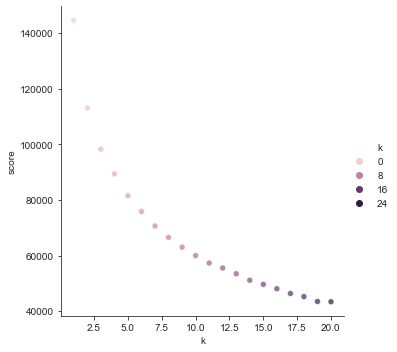

In [23]:
# find best K use elbow rule
tmp=[]
for k in range(1,21,1):
    m=KMeans(n_clusters=k, random_state=0).fit(X)
    s=m.score(X)
    tmp.append([k,-s])   
draw_elbow_rule_(tmp)

df_pca['kmeans_group']=KMeans(n_clusters=6, random_state=0).fit_predict(X)

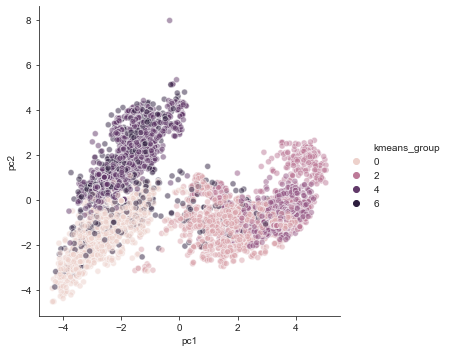

In [24]:
draw_cluster_('kmeans_group')

### 4.3GaussianMixture [soft-cluster]

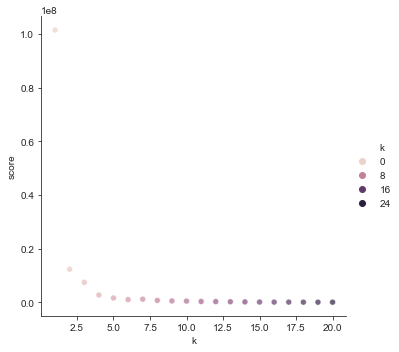

In [25]:
# find best K use elbow rule
tmp=[]
for k in range(1,21,1):
    m=GaussianMixture(n_components=k, random_state=0).fit(X)
    s=m.score(X)
    tmp.append([k,np.exp(-s)]) #original score under log scale, transform it to find 'elbow'
draw_elbow_rule_(tmp)   

df_pca['GM_group']=GaussianMixture(n_components=6, random_state=0).fit_predict(X)

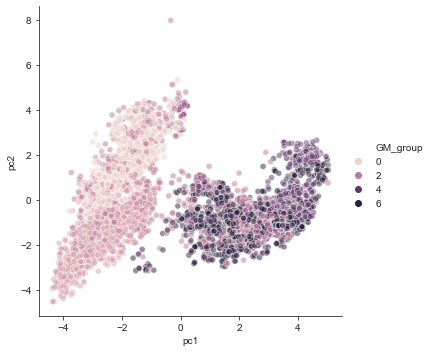

In [26]:
draw_cluster_('GM_group')

### 4.4cluster relationship

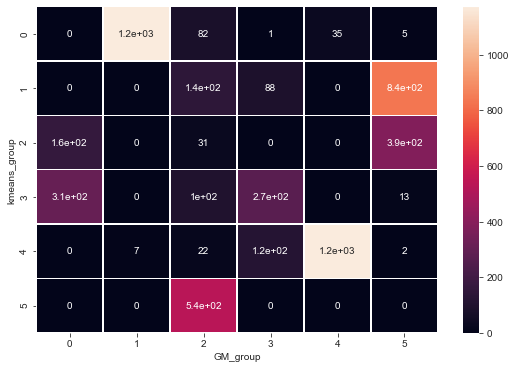

In [27]:
#change group name for better vis
df_pca['GM_group']=df_pca['GM_group'].map({0:4,1:1,2:2,3:3,4:0,5:5})

draw_cluster_relationship_('kmeans_group','GM_group')

### 4.5other method 
 - those method is hard to evaluate by itself
 - maybe those information is useful in supervised-learning

In [28]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# arbitrary hyper parameters
df_pca['Agg_group']=AgglomerativeClustering(n_clusters=6).fit_predict(X)
df_pca['DB_group']=DBSCAN(min_samples=10).fit_predict(X)

df_pca.head(10)

,ID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,kmeans_group,GM_group,Agg_group,DB_group
0,3338,-2.845885,-0.264157,3.697249,3.736717,1.751160,0.335955,-1.065584,-0.313493,-1.489082,-0.571237,5,2,3,-1
1,3687,-2.865004,-0.687953,1.133487,0.940399,2.202690,0.647297,-3.069416,-0.240299,-1.661721,0.967207,4,4,0,-1
2,3970,-2.738506,-0.598430,0.752908,0.700448,2.434037,0.258367,-2.836127,-0.214992,-1.099275,0.302775,4,4,0,-1
3,5015,-2.867102,-0.625772,0.519776,0.644845,2.327448,0.306585,-2.965686,-0.223626,-0.837231,0.097431,4,4,0,-1
4,5671,-3.227287,-1.168869,3.404158,3.800628,1.535034,-0.345131,-1.070708,-1.222908,-1.017826,-1.848070,5,2,3,-1
5,5678,-2.780779,0.445981,3.531229,2.823454,2.529369,-0.243158,-1.333254,-0.485518,-1.949483,-0.261469,5,2,3,-1
6,5915,-2.726391,-0.721256,0.653545,0.583094,2.519801,0.019756,-2.655973,-0.478348,-1.076853,0.081140,4,4,0,-1
7,6940,-2.530086,-0.359989,0.942891,0.442824,1.452727,-0.115797,-1.945076,-1.964696,-1.162357,0.278374,4,4,0,-1
8,6953,-2.600102,-0.627036,0.486182,1.219894,2.788738,-0.317506,-1.383605,-0.630562,-1.126194,0.571983,4,2,0,-1
9,7319,-2.788862,0.215938,0.970149,0.311379,3.053544,-0.349703,-2.453762,-0.434090,-1.726813,0.455402,4,4,0,-1


## 5.business conclusion
 - more cluster is good for reduce distance matrix, but it is hard to explanation
 - in this part, we will focus on how unsupervised-learning can help make business conclusion :-)


### 5.1 re-cluster (from 6 clusters to 3 clusters) and match target variable (meet SLA)

In [29]:
df_x=df_pca.copy(deep=True)

df_x['kmeans_group']=KMeans(n_clusters=3, random_state=0).fit_predict(X)
df_x['GM_group']=GaussianMixture(n_components=3, random_state=0).fit_predict(X)
df_x['Agg_group']=AgglomerativeClustering(n_clusters=3).fit_predict(X)

df_x.shape

(5490, 15)

In [30]:
#define target varible
df_y=pd.read_csv('Data/Data_I-hope.csv',
                 usecols=['ID','PlanStartDate','PlanFinishDate','ActualFinishDate','SLA','Status'])

df_y=df_y[(df_y['Status'].str.contains('complete')) | df_y['Status'].str.contains('Complete')]
df_y=df_y.dropna(subset=['ActualFinishDate'])


df_y = df_y.reset_index()
df_y = df_y.dropna(subset=['PlanFinishDate'])
mi_holidays = holidays.UnitedStates(state='MI')

start = df_y['PlanStartDate'].astype(str)
end = df_y['ActualFinishDate'].astype(str)
    
bus = []
holi = []
dur = []
start_list = start.tolist()
end_list = end.tolist()
for i in range(len(start_list)):
    holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
    bus.append(np.busday_count(start_list[i], end_list[i]))

zip_object = zip(bus, holi)
for list1_i, list2_i in zip_object:
    dur.append(list1_i-list2_i)
df_y['duration'] = dur


df_y['Met_SLA']=1.
df_y.loc[df_y['SLA']<df_y['duration'],'Met_SLA']=0.

df_y=df_y[['ID','Met_SLA']]
df_y=df_y.drop_duplicates(subset=['ID'])
df_y=df_y.dropna(subset=['ID'])

df_y.shape

(2067, 2)

In [31]:
df=df_x.merge(df_y,on='ID',how='left')\
       .merge(df_ori[['ID']+num_cols+cat_cols],on='ID',how='left')

df['Met_SLA']=df['Met_SLA'].fillna(-1) # indicate we do not know whether it met SLA or not

df.columns

Index(['ID', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9',
       'pc10', 'kmeans_group', 'GM_group', 'Agg_group', 'DB_group', 'Met_SLA',
       'Sensitivity', 'DollarAmount', 'SizeOfSpend', 'BusinessProcessImpact',
       'Leveragability', 'PublicSafety', 'MultiAgency', 'Hours', 'TechChange',
       'MarketRisk', 'LevelCalc', 'BuyerName', 'CreatedBy', 'Division_x',
       'Grouping', 'ProjectType', 'WorkPerformedFor', 'BuyerInitials'],
      dtype='object')

### 5.2 cluster attributes

In [32]:
tmp=df.groupby(['kmeans_group'])\
      .agg({'TechChange':['mean'],
            'Leveragability':['mean'],
            'Sensitivity':['mean'],
            'LevelCalc':['mean'],
            'BusinessProcessImpact':['mean'],
            'Hours':['mean'],
            'DollarAmount':['mean'],
            'MarketRisk':['mean'],
            'SizeOfSpend':['mean'],
            'PublicSafety':['mean'],
            'MultiAgency':['mean'],
            'CreatedBy':[lambda x:x.value_counts().index[0]],
            'Grouping':[lambda x:x.value_counts().index[0]],
            'BuyerInitials':[lambda x:x.value_counts().index[0]],
            'WorkPerformedFor':[lambda x:x.value_counts().index[0]],
            'BuyerName':[lambda x:x.value_counts().index[0]],
            'ProjectType':[lambda x:x.value_counts().index[0]],
            'Division_x':[lambda x:x.value_counts().index[0]]})

tmp=tmp.reset_index()
tmp.columns=[x[0] for x in tmp.columns]
tmp

,kmeans_group,TechChange,Leveragability,Sensitivity,LevelCalc,BusinessProcessImpact,Hours,DollarAmount,MarketRisk,SizeOfSpend,PublicSafety,MultiAgency,CreatedBy,Grouping,BuyerInitials,WorkPerformedFor,BuyerName,ProjectType,Division_x
0,0,2.188793,3.545697,2.546364,2.870580,2.808539,18.196131,2.167913e+06,1.824550,3.513009,2.752502,3.655771,riggs,other,other,0,other,CN,COMM
1,1,3.154235,4.501264,3.479140,3.480405,2.721871,27.407712,3.739957e+07,2.451327,3.979140,2.001264,3.520860,EdgettC,other,other,other,other,CN,PROF
2,2,4.794105,3.576173,3.789539,3.689083,3.276463,15.285181,1.368766e+06,1.594438,4.024907,1.953923,3.915318,BronzJ,IT Systems and Software,JAB,other,other,CN,IT


nemuric part---


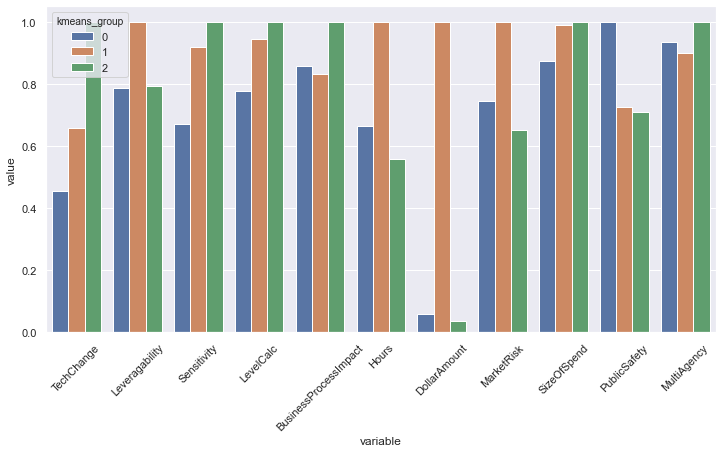

In [33]:
graph_=tmp.copy(deep=True)

melt_features=['TechChange','Leveragability','Sensitivity','LevelCalc',
               'BusinessProcessImpact','Hours','DollarAmount','MarketRisk',
               'SizeOfSpend','PublicSafety','MultiAgency']

for col in melt_features:
    graph_[col]=graph_[col]/graph_[col].max()

graph_=pd.melt(graph_, id_vars=['kmeans_group'], value_vars=melt_features)

print('nemuric part---')
sns.set(rc={'figure.figsize':(12,6)})
chart=sns.barplot(x="variable", y="value", hue="kmeans_group", data=graph_)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

categorical part---


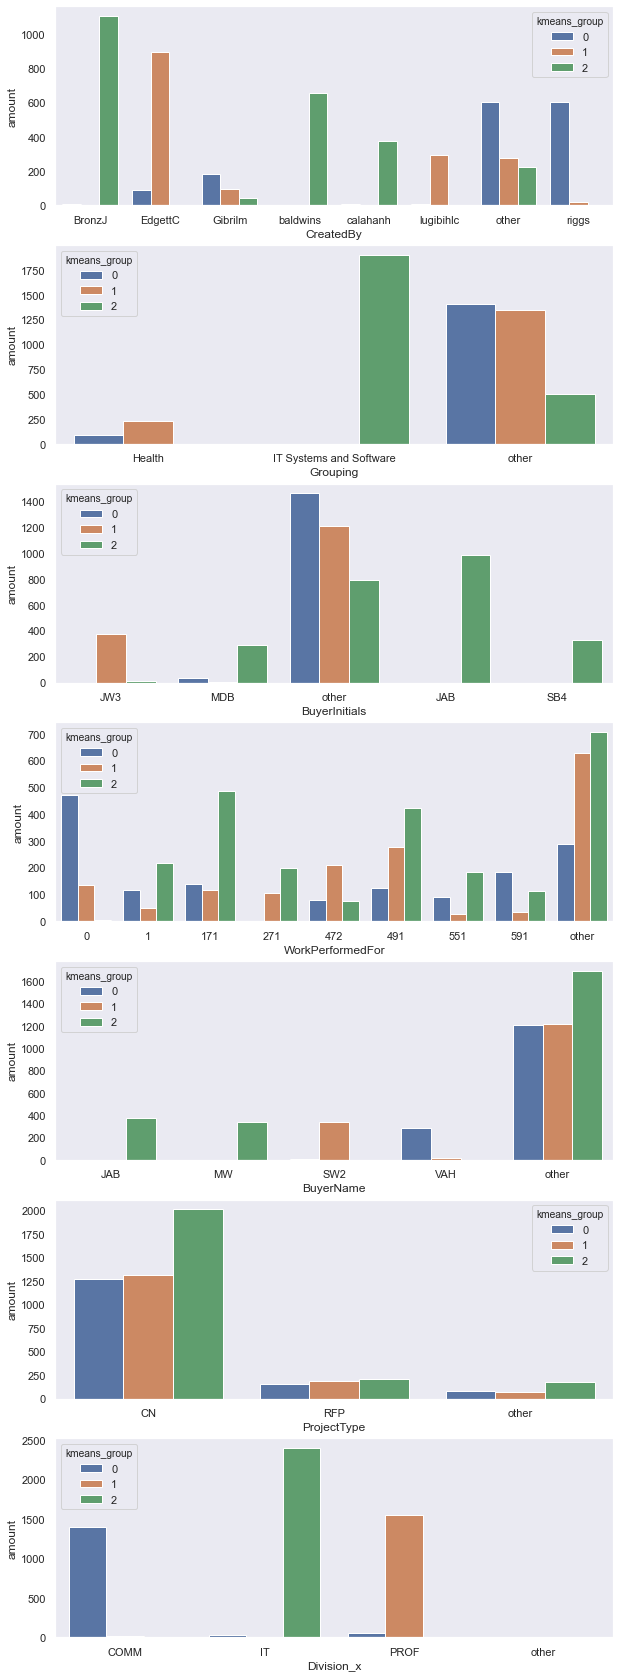

In [34]:
print('categorical part---')

sns.set(rc={'figure.figsize':(10,30)})
f, axes = plt.subplots(7, 1)

cat_features=['CreatedBy','Grouping','BuyerInitials','WorkPerformedFor','BuyerName','ProjectType','Division_x']
for col in cat_features:
    tmp=df.groupby(['kmeans_group',col]).agg({'ID':'count'}).reset_index()
    tmp.columns=['kmeans_group',col,'amount']
    
    sns.barplot(x=col, y='amount', hue='kmeans_group', data=tmp, ax=axes[cat_features.index(col)])\
       .grid(False)    

### 5.3conclusion
 - 1.As hours shows, project in cluster0 takes more time to be finished compare with other clusters.
 - 2.from scales(dollar) view, project in cluster0 is much bigger other clusters.
 - 3.most poject in cluster0 belongs to Division-PROF, as (cluster1,Division-COMM), (cluster2,Division-IT)

## 6.Bivariate Analysis
 - explore relationship between feature and target variable
 - features: pc1 kmeans_group
 - target variable: Met_SLA

## 6.1 does unsupervised-learning features has higher predict power than original features?

In [35]:
df_tmp=df[df['Met_SLA'].isin([0,1])].copy(deep=True)

df_ori=df_tmp[['Hours', 'PublicSafety', 'MarketRisk', 'MultiAgency', 'Leveragability',
              'DollarAmount', 'LevelCalc', 'BusinessProcessImpact', 'Sensitivity',
              'SizeOfSpend', 'TechChange','Met_SLA']].copy(deep=True)

df_unsup=df_tmp[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9',
                'pc10', 'kmeans_group', 'GM_group', 'Agg_group','Met_SLA']].copy(deep=True)

In [36]:
# quantile each variable before compare
# 1 after quantile -- 0%-33%
# 2 after quantile -- 33%-66%
# 3 after quantile -- 66%-99%

for col in df_ori.columns:
    df_ori[col]=pd.to_numeric(df_ori[col])
    # cols below has duplicates quantile, so pass
    if col in ['Met_SLA','PublicSafety','MarketRisk','MultiAgency','Leveragability','BusinessProcessImpact',
               'Sensitivity','SizeOfSpend','TechChange','LevelCalc']:
        continue
    df_ori[col]=pd.qcut(df_ori[col], 3, labels=[1,2,3],duplicates='drop')
        
for col in df_unsup.columns:
    df_unsup[col]=pd.to_numeric(df_unsup[col])
    # cols below has duplicates quantile, so pass
    if col in ['Met_SLA','kmeans_group','GM_group','Agg_group']:
        continue
    df_unsup[col]=pd.qcut(df_unsup[col], 3, labels=[1,2,3],duplicates='drop')

In [37]:
def observe_correlation_(df,col):
    tmp=df.groupby([col]).agg({'Met_SLA':['sum','count']}).reset_index()
    tmp.columns=[col,'Met_SLA','total']
    tmp['Met_ratio']=tmp['Met_SLA']/tmp['total']
    return tmp

### 6.1.1 original feature examples

In [38]:
observe_correlation_(df_ori,'Hours')

,Hours,Met_SLA,total,Met_ratio
0,1,600.0,709,0.846262
1,2,668.0,714,0.935574
2,3,473.0,644,0.734472


In [39]:
observe_correlation_(df_ori,'DollarAmount')

,DollarAmount,Met_SLA,total,Met_ratio
0,1,814.0,922,0.882863
1,2,414.0,456,0.907895
2,3,513.0,689,0.744557


### 6.1.1 unsupervised-learning feature examples

In [40]:
observe_correlation_(df_unsup,'pc1')

,pc1,Met_SLA,total,Met_ratio
0,1,620.0,689,0.899855
1,2,543.0,689,0.788099
2,3,578.0,689,0.838897


In [41]:
observe_correlation_(df_unsup,'kmeans_group')

,kmeans_group,Met_SLA,total,Met_ratio
0,0,366.0,405,0.903704
1,1,366.0,419,0.873508
2,2,1009.0,1243,0.811746


### 6.1.3 formal method chi-square test

In [42]:
def chi2_test_(df):
    res=[]
    
    for col in df.columns:
        
        if col in ['Met_SLA']:
            continue
            
        contingency_table=pd.crosstab(df[col],df['Met_SLA'])
        chi2, p, dof, ex=scipy.stats.chi2_contingency(contingency_table)
        
        res.append([col,chi2,p])
        
    return pd.DataFrame(res,columns=['variable','chi2_value','p_value'])

In [43]:
chi2_test_(df_ori)

,variable,chi2_value,p_value
0,Hours,103.210515,3.873660e-23
1,PublicSafety,4.767166,1.896622e-01
2,MarketRisk,3.285332,1.934636e-01
3,MultiAgency,22.089312,1.923806e-04
4,Leveragability,26.900767,1.440697e-06
5,DollarAmount,75.740443,3.574143e-17
6,LevelCalc,14.223754,6.614127e-03
7,BusinessProcessImpact,8.878404,6.421171e-02
8,Sensitivity,5.419869,6.654117e-02
9,SizeOfSpend,4.088698,3.941349e-01


In [44]:
chi2_test_(df_unsup)

,variable,chi2_value,p_value
0,pc1,32.478172,8.860426e-08
1,pc2,0.050986,9.748291e-01
2,pc3,21.006290,2.744998e-05
3,pc4,53.870500,2.005255e-12
4,pc5,3.874947,1.440675e-01
5,pc6,5.710448,5.754294e-02
6,pc7,5.601192,6.077384e-02
7,pc8,9.752920,7.623954e-03
8,pc9,9.971432,6.834881e-03
9,pc10,1.799082,4.067562e-01


### 6.1.4 conclusion
 - 1. It is really hard to say whether ori-features or pc-features are better.
 - 2. group-features are better than ori-features, because p value for each group-features is lower than 0.05, indicates that there is a strong relationship between group-feature and Met_SLA.
 - 3. So, unsupervied-learning may improve classification result in this dataset.

## 6.2 group-features VIS

In [45]:
def VIS_group_(group_):

    sns.set(rc={'figure.figsize':(10,6)})
    tmp=df[df['Met_SLA']>=0].groupby([group_]).agg({'Met_SLA':['sum','count']}).reset_index()
    tmp.columns=[group_,'LSA_sum','count']
    tmp['Met_ratio']=tmp['LSA_sum']/tmp['count']

    print(tmp)
    sns.barplot(x=tmp[group_],y=tmp['Met_ratio']).grid(False)

   kmeans_group  LSA_sum  count  Met_ratio
0             0    366.0    405   0.903704
1             1    366.0    419   0.873508
2             2   1009.0   1243   0.811746


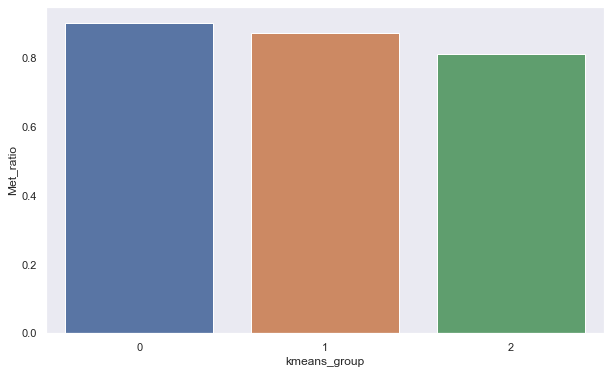

In [46]:
VIS_group_('kmeans_group')

   GM_group  LSA_sum  count  Met_ratio
0         0    385.0    441   0.873016
1         1    341.0    373   0.914209
2         2   1015.0   1253   0.810056


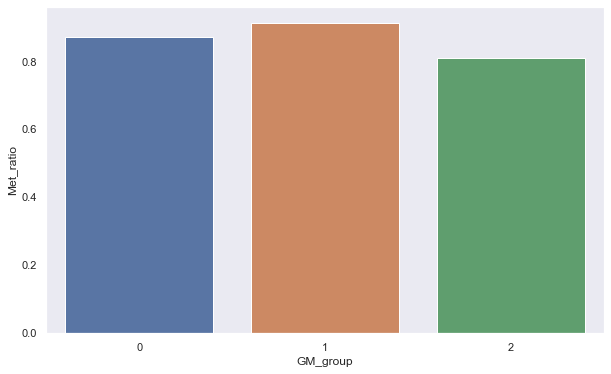

In [47]:
VIS_group_('GM_group')

   Agg_group  LSA_sum  count  Met_ratio
0          0    406.0    475   0.854737
1          1   1005.0   1239   0.811138
2          2    330.0    353   0.934844


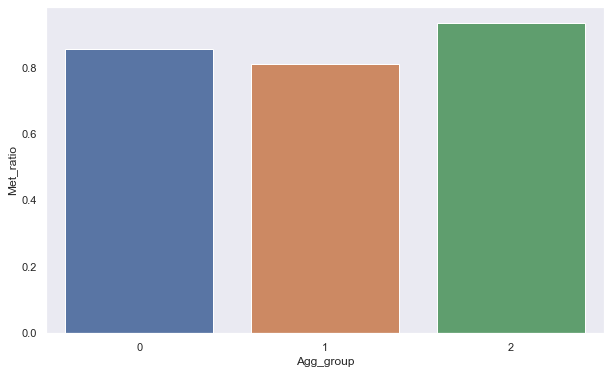

In [48]:
VIS_group_('Agg_group')